In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist # mnist 훈련셋과 테스트셋
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from tensorflow.keras.models import Sequential, save_model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.layers import LeakyReLU,ELU,ReLU
from matplotlib import pyplot as plt # 학습과정 시각화
# scale조정, train_test_split 등을 추가

In [3]:
# mnist 데이터 일부(30개)를 이미지 출력하기(plt.imshow하기)
(X_train,y_train),(X_test,y_test) = mnist.load_data()
X_test.shape,y_test.shape

((10000, 28, 28), (10000,))

In [4]:
y_test[:30]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1], dtype=uint8)

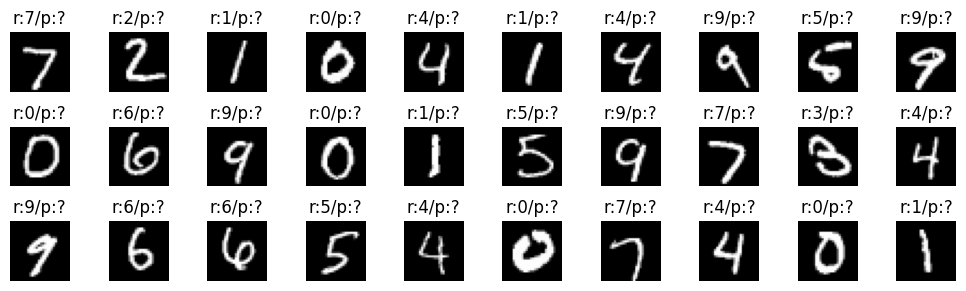

In [19]:
plt_row = 3
plt_col = 10
# plt.figure(figsize=(plt_col,plt_row))
plt.rcParams['figure.figsize'] = (plt_col,plt_row)
fig,axarr = plt.subplots(nrows=plt_row,ncols=plt_col)
#plt.subplots_adjust(hspace=0.4,wspace=0.3)
# axarr[1,1].imshow(X_test[11],cmap='gray')
# axarr[1,1].axis('off')
# axarr[1,1].set_title(f'real:{y_test[11]}')
for i in range(plt_row*plt_col):
    ax = axarr[i//plt_col,i%plt_col]
    ax.imshow(X_test[i],cmap='gray')
    ax.axis('off')
    ax.set_title(f'r:{y_test[i]}/p:?')
plt.tight_layout()

# 1. DNN

In [22]:
%%time
(X_train,y_train),(X_test,y_test) = mnist.load_data()
# Train데이터 6만개 => Train(5만개) + val(1만개)로 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

# 입력(독립) 변수 (n,28,28) => (n,28*28) => 실수형변환 -> 스케일 조정(/255.0)
train_X = X_train.reshape(50000,28*28).astype('float32')/255.0
val_X   = X_val.reshape(-1,784).astype('float32')/255.0
test_X  = X_test.reshape(10000,-1).astype('float32')/255.0

# 분류분석을 위한 타겟변수의 원핫인코딩
# print(y_train[0])

# to_categorical(y_train)[0]
train_Y = to_categorical(y_train,10)  # 10: 카테고리수(안쓰면 자동 입력)
val_Y   = to_categorical(y_val)
test_Y = to_categorical(y_test)

# 모델 생성
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=1024,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(0.3))
# model.ad(Relu())  ==  model.add(Dense(units=2),activation='Relu')
model.add(LeakyReLU(alpha=0.01))   # alpha=0.01: 음수결과에 대해 1%만 통과 (0.3이 기본) / LeakyReLU는 한 layer 더 만듦
model.add(Dense(units=10,activation='softmax'))
# print(model.summary())
# 컴파일
model.compile(loss ='categorical_crossentropy',   # sparse_categorical_crossentropy
             optimizer='adam',
             metrics=['accuracy']) # 평가지표

hist = model.fit(train_X,train_Y, # 학습셋
                epochs=20,
                batch_size=100,
                validation_data=(val_X,val_Y),
                verbose=1)

Epoch 1/20
500/500 [==============================] - 5s 9ms/step - loss: 0.2918 - accuracy: 0.9104 - val_loss: 0.1267 - val_accuracy: 0.9638
Epoch 2/20
500/500 [==============================] - 4s 8ms/step - loss: 0.1271 - accuracy: 0.9614 - val_loss: 0.0935 - val_accuracy: 0.9735
Epoch 3/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0981 - accuracy: 0.9704 - val_loss: 0.0845 - val_accuracy: 0.9742
Epoch 4/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0840 - accuracy: 0.9746 - val_loss: 0.0821 - val_accuracy: 0.9768
Epoch 5/20
500/500 [==============================] - 4s 9ms/step - loss: 0.0678 - accuracy: 0.9789 - val_loss: 0.0778 - val_accuracy: 0.9785
Epoch 6/20
500/500 [==============================] - 5s 9ms/step - loss: 0.0588 - accuracy: 0.9811 - val_loss: 0.0739 - val_accuracy: 0.9797
Epoch 7/20
500/500 [==============================] - 5s 9ms/step - loss: 0.0530 - accuracy: 0.9835 - val_loss: 0.0787 - val_accuracy: 0.9786
Epoch 

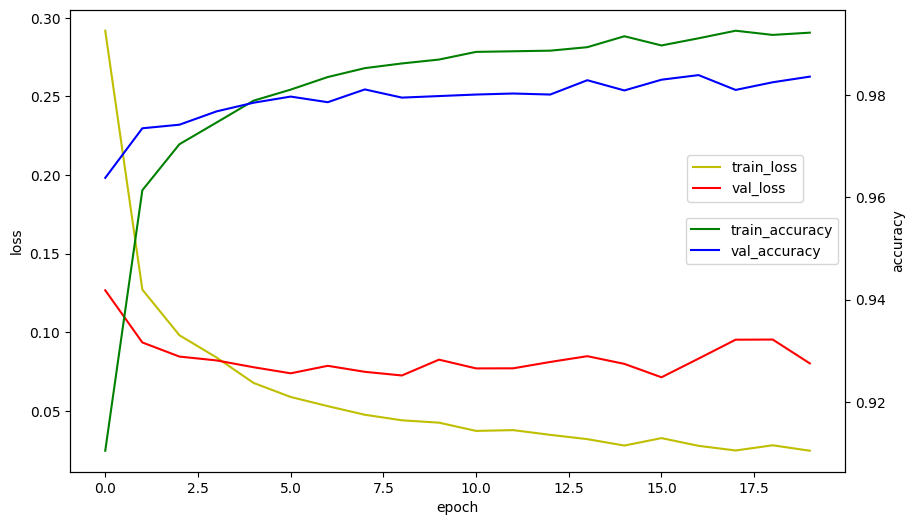

In [23]:
hist.history.keys()
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [25]:
# 모델평가
loss,acc = model.evaluate(test_X,test_Y,verbose=0)
acc

0.982699990272522

In [26]:
# 틀린갯수
len(test_Y) - len(test_Y)*acc

173.00009727478027

In [31]:
# 틀린 이미지만 출력하기 위해, 예측값과 실제값과 예측값
# 실제값들
real = test_Y.argmax(axis=1)
real = np.argmax(test_Y,axis=1)
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [32]:
np.all(test_Y.argmax(axis=1) == y_test)

True

In [37]:
# 예측값
y_hat = model.predict(test_X,verbose=0).argmax(axis=1)

In [38]:
y_test.shape,y_hat.shape  #실제값과 예측값

((10000,), (10000,))

In [39]:
# 성능 평가표 (교차표,혼동행렬)
pd.crosstab(y_test,y_hat)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,971,1,0,0,0,1,5,1,1,0
1,0,1120,3,1,0,1,6,1,3,0
2,1,0,1016,0,2,0,3,6,4,0
3,0,0,1,997,0,5,0,3,3,1
4,1,1,0,0,961,0,6,2,2,9
5,3,0,0,6,0,875,5,0,3,0
6,2,2,0,0,1,3,949,0,1,0
7,0,3,5,1,1,0,0,1004,6,8
8,0,1,2,8,1,5,3,2,950,2


In [41]:
plt_row = 11
plt_col = 10
i = 0;  # y_hat과 y_test를 엑세스할 index: 0 ~ 9999
cnt = 0 # 이미지 출력 횟수  : 1 ~ 120 plt_row = 12
while (cnt<plt_row*plt_col) & (i<len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    print(title,end='\t')
    i  += 1
    cnt += 1

r:5/p:6	r:4/p:9	r:8/p:5	r:4/p:6	r:2/p:7	r:5/p:3	r:6/p:0	r:8/p:2	r:1/p:8	r:2/p:6	r:5/p:3	r:7/p:3	r:8/p:9	r:1/p:7	r:5/p:8	r:4/p:9	r:1/p:3	r:3/p:5	r:8/p:9	r:1/p:6	r:2/p:7	r:6/p:5	r:9/p:3	r:4/p:6	r:7/p:8	r:6/p:5	r:7/p:2	r:4/p:9	r:9/p:5	r:8/p:3	r:7/p:9	r:5/p:3	r:7/p:9	r:7/p:9	r:1/p:5	r:8/p:7	r:4/p:6	r:9/p:3	r:2/p:6	r:0/p:6	r:3/p:7	r:2/p:8	r:3/p:2	r:8/p:3	r:9/p:4	r:7/p:8	r:8/p:2	r:8/p:3	r:7/p:9	r:4/p:8	r:4/p:9	r:7/p:1	r:8/p:1	r:3/p:7	r:4/p:9	r:6/p:1	r:1/p:2	r:9/p:1	r:9/p:5	r:5/p:8	r:9/p:1	r:9/p:4	r:9/p:4	r:2/p:4	r:9/p:7	r:5/p:3	r:7/p:1	r:9/p:0	r:6/p:1	r:7/p:4	r:4/p:7	r:9/p:5	r:3/p:5	r:8/p:5	r:1/p:2	r:6/p:0	r:7/p:9	r:1/p:6	r:3/p:7	r:4/p:9	r:9/p:1	r:6/p:4	r:5/p:0	r:8/p:5	r:9/p:3	r:5/p:8	r:4/p:6	r:7/p:8	r:7/p:1	r:1/p:2	r:9/p:3	r:4/p:6	r:9/p:4	r:3/p:5	r:0/p:8	r:8/p:3	r:9/p:3	r:9/p:0	r:2/p:7	r:7/p:9	r:2/p:8	r:2/p:8	r:9/p:3	r:5/p:3	r:8/p:7	r:2/p:7	r:6/p:5	r:5/p:6	r:6/p:8	r:8/p:4	

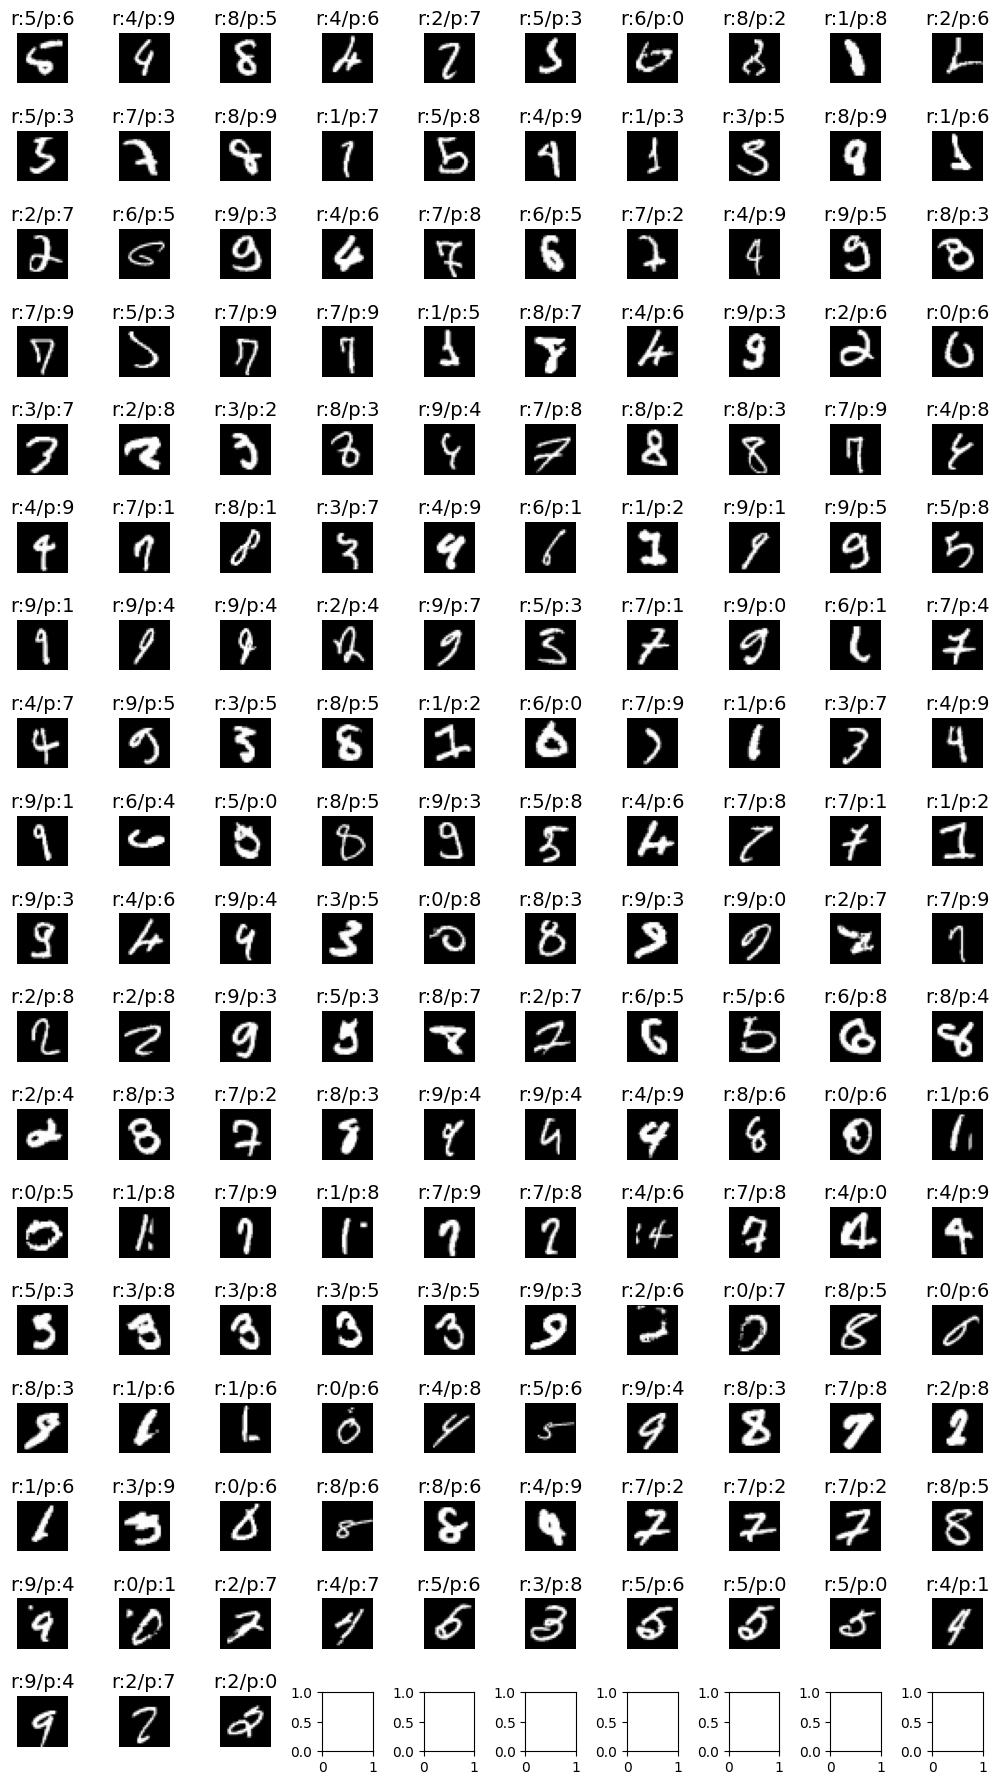

In [43]:
plt_row = 18
plt_col = 10

plt.rcParams['figure.figsize'] = (plt_col,plt_row)
fig,axarr = plt.subplots(nrows=plt_row,ncols=plt_col)
#plt.subplots_adjust(hspace=0.4,wspace=0.3)

i = 0;  # y_hat과 y_test를 엑세스할 index: 0 ~ 9999
cnt = 0 # 이미지 출력 횟수  : 1 ~ 180 plt_row = 18
while (cnt<plt_row*plt_col) & (i<len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    ax = axarr[cnt//plt_col,cnt%plt_col]
    ax.imshow(X_test[i],cmap='gray')
    ax.axis('off')
    ax.set_title(title,fontsize=14)
    i  += 1
    cnt += 1

plt.tight_layout()

# 2. CNN
- 컨볼루션 layer -> pooling -> 컨볼루션 layer -> pooling -> 컨볼루션 layer -> pooling -> Flatten (1차원으로) -> DNN

In [62]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist # mnist 훈련셋과 테스트셋
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from tensorflow.keras.models import Sequential, save_model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.layers import LeakyReLU,ELU,ReLU

from sklearn.metrics import recall_score, precision_score,accuracy_score,f1_score, confusion_matrix
# CNN
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [58]:
width = 28; height = 28
model = Sequential([
        Conv2D(filters=32,     # 필터수
               kernel_size=3,  # 필터사이즈 3*3
               padding='same', # zero-padding / padding='valid' 기본값
               input_shape = (width,height,1), # (width,height,1) 흑백1채널, 3 칼라
               activation='relu'
        ), # 28*28 1채널 이미지를 32개 필터로 특성맵 추출 => 28*28*32특성맵 
        MaxPool2D(pool_size=(2,2)),  # 가로 2배, 세로 2배 전체 4배 줄어듦
        Dropout(0.1),
        Conv2D(filters=64,kernel_size=(3,3),activation='relu'),  # padding 처리 안함 valid
        MaxPool2D(pool_size=(2,2)),
        Dropout(0.25),
        Flatten(),   # 2304
        Dense(units=128,activation='relu'),
        Dropout(0.4),
        Dense(units=10,activation='softmax')
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 6, 6, 64)        

In [64]:
%%time
# 1. 데이터 생성 & 전처리
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Train데이터 6만개 => Train(5만개) + val(만개)로 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]
train_X = X_train.astype('float32')/255.0
val_X   = X_val.astype('float32')/255.0
test_X  = X_test.astype('float32')/255.0

train_Y = to_categorical(y_train)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)
train_X.shape, train_Y.shape, val_X.shape, val_Y.shape, test_X.shape, test_Y.shape
# 2. 모델 생성
width=28; height=28
model = Sequential()
model.add(Conv2D(32, 3, padding='same', 
                 input_shape=(width, height, 1), activation='relu'
        ))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=10, activation='softmax'))
# 3. 학습과정 설정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 4. 학습하기
early_stopping = EarlyStopping(patience=10)
checkpoint = ModelCheckpoint(
    filepath='mnist-{epoch:02d}-loss{val_loss:.4f}-val{val_accuracy:.4f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode = 'max',
    verbose=1
)
hist = model.fit(train_X, train_Y, epochs=50, batch_size=32,
                validation_data=(val_X, val_Y),
                callbacks=[early_stopping, checkpoint])

Epoch 1/50
1560/1563 [============================>.] - ETA: 0s - loss: 0.2268 - accuracy: 0.9293
Epoch 1: val_accuracy improved from -inf to 0.98470, saving model to mnist-01-loss0.0537-val0.9847.h5
1563/1563 [==============================] - 22s 14ms/step - loss: 0.2267 - accuracy: 0.9293 - val_loss: 0.0537 - val_accuracy: 0.9847
Epoch 2/50
1560/1563 [============================>.] - ETA: 0s - loss: 0.0828 - accuracy: 0.9760
Epoch 2: val_accuracy improved from 0.98470 to 0.98530, saving model to mnist-02-loss0.0489-val0.9853.h5
1563/1563 [==============================] - 21s 14ms/step - loss: 0.0828 - accuracy: 0.9760 - val_loss: 0.0489 - val_accuracy: 0.9853
Epoch 3/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.0608 - accuracy: 0.9813
Epoch 3: val_accuracy improved from 0.98530 to 0.98960, saving model to mnist-03-loss0.0371-val0.9896.h5
1563/1563 [==============================] - 23s 15ms/step - loss: 0.0608 - accuracy: 0.9813 - val_loss: 0.0371 - val_accura

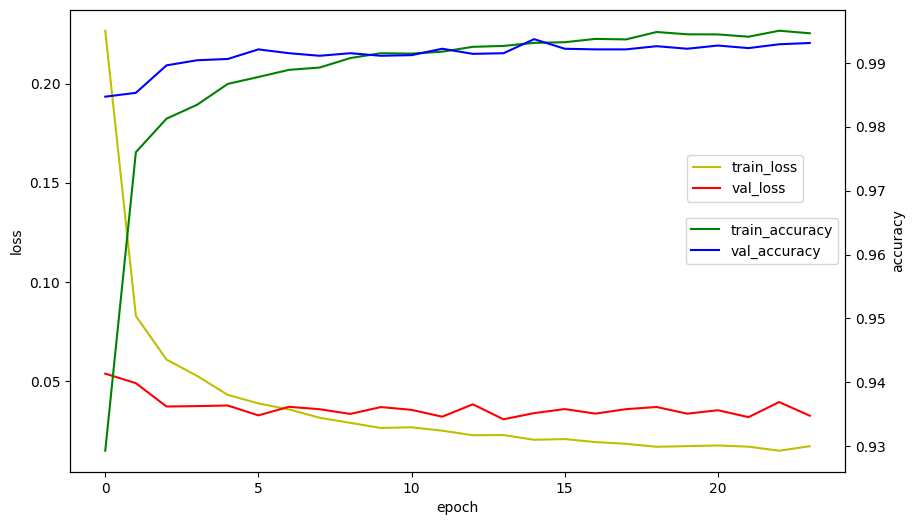

In [65]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [66]:
# 모델 평가
loss, acc = model.evaluate(test_X,test_Y,verbose=0)
print('최종 모델 :', acc,loss)

최종 모델 : 0.9936000108718872 0.02684425376355648


In [67]:
model1 = load_model('mnist-15-loss0.0338-val0.9937.h5')
loss1,acc1 = model1.evaluate(test_X,test_Y,verbose=0)
print('model1 :', acc1,loss1)

model1 : 0.9932000041007996 0.02347666211426258


In [70]:
model2 = load_model('mnist-12-loss0.0320-val0.9922.h5')
loss2,acc2 = model2.evaluate(test_X,test_Y,verbose=0)
print('model2 :', acc2,loss2)

model2 : 0.992900013923645 0.022296413779258728


In [71]:
model3 = load_model('mnist-06-loss0.0326-val0.9921.h5')
loss3,acc3 = model3.evaluate(test_X,test_Y,verbose=0)
print('model3 :', acc3,loss3)

model3 : 0.9918000102043152 0.02829597145318985


In [72]:
model4 = load_model('mnist-05-loss0.0376-val0.9906.h5')
loss4,acc4 = model4.evaluate(test_X,test_Y,verbose=0)
print('model4 :', acc4,loss4)

model4 : 0.9908000230789185 0.027755197137594223


In [76]:
# 성능 평가(성능평가지표=교차표,혼동행렬, acc,recall,precision, f1)를 위해 실제값, 예측값
# y_test : 실제값
y_hat = model.predict(test_X,verbose=0).argmax(axis=1)  # 예측값

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [77]:
pd.crosstab(y_test,y_hat)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,971,1,0,0,0,1,5,1,1,0
1,0,1120,3,1,0,1,6,1,3,0
2,1,0,1016,0,2,0,3,6,4,0
3,0,0,1,997,0,5,0,3,3,1
4,1,1,0,0,961,0,6,2,2,9
5,3,0,0,6,0,875,5,0,3,0
6,2,2,0,0,1,3,949,0,1,0
7,0,3,5,1,1,0,0,1004,6,8
8,0,1,2,8,1,5,3,2,950,2


In [84]:
print('accuracy :',accuracy_score(y_test,y_hat))
# 다중 분류의 타겟변수의 균형이 비슷하면 'macro' / 균형이 안잡힌 데이터면 'weighted'
print('recall :',recall_score(y_test,y_hat,average='weighted'))
print('precision :',precision_score(y_test,y_hat,average='weighted'))
print('f1_score :', f1_score(y_test,y_hat,average='weighted'))


accuracy : 0.9827
recall : 0.9827
precision : 0.9827348470515724
f1_score : 0.9827015719391715


In [85]:
# 틀린갯수
len(y_test)-len(y_test)*acc

63.99989128112793

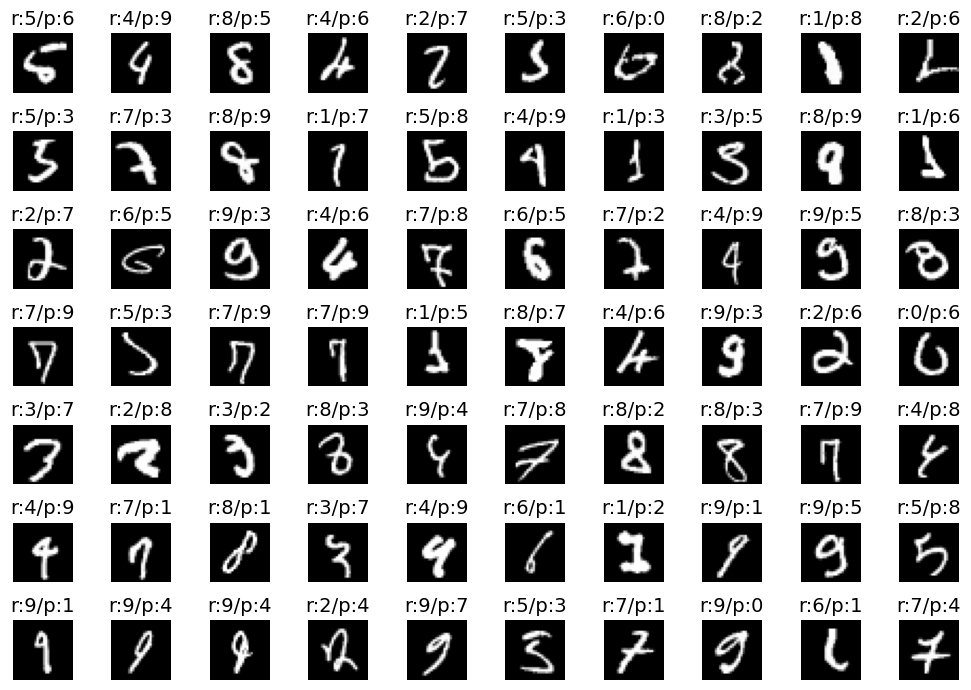

In [86]:
plt_row = 7
plt_col = 10

plt.rcParams['figure.figsize'] = (plt_col,plt_row)
fig,axarr = plt.subplots(nrows=plt_row,ncols=plt_col)
#plt.subplots_adjust(hspace=0.4,wspace=0.3)

i = 0;  # y_hat과 y_test를 엑세스할 index: 0 ~ 9999
cnt = 0 # 이미지 출력 횟수  : 1 ~ 180 plt_row = 18
while (cnt<plt_row*plt_col) & (i<len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    ax = axarr[cnt//plt_col,cnt%plt_col]
    ax.imshow(X_test[i],cmap='gray')
    ax.axis('off')
    ax.set_title(title,fontsize=14)
    i  += 1
    cnt += 1

plt.tight_layout()